# Denoising Posterior Comparison

In [1]:
%matplotlib inline
from model import *
import torch
import seaborn as sns
from utils import *
from mmd import *
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from sklearn.datasets import make_circles

## True posterior 

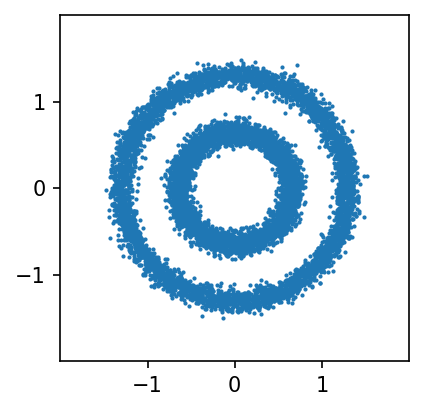

In [2]:

palette = sns.color_palette()

sample_num=10000

dataset,_=make_circles(sample_num,noise=0.05,factor=0.5)
dataset=torch.tensor(dataset).float()*1.3

test_dataset,_=make_circles(sample_num,noise=0.05,factor=0.5)
test_dataset=torch.tensor(test_dataset).float()*1.3

get_plt()
plt.scatter(*dataset.T, alpha=1., color=palette[0], s=1);
plt.show()

In [3]:
opt={
    'epochs':100,
    'batch_size':100,
    'test_batch_size':100,
    'gibbs_steps':10000,
    'device':'cuda:0',
    'noise_std':0.2,
    'x_dim':2,
    'layer_num':3,
    'lr':1e-4,
    'act':'swish',
    'seed':0,
}


# 1. Learning the mean and the vairance by KL minimization

100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.69it/s]


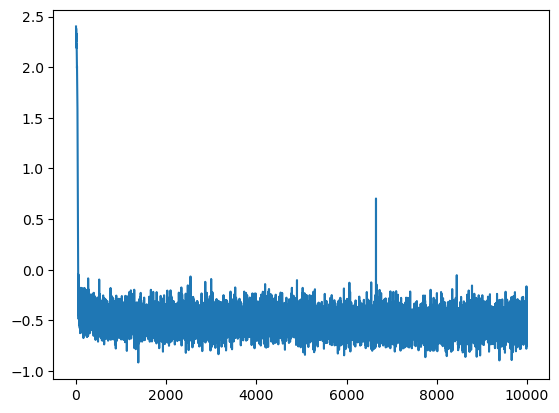

In [4]:

np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])

model1=DenoiserLearnedVar(opt)
loss_list=[]

model1.train()
iterations=int(dataset.size()[0]/opt['batch_size'])
for t in tqdm(range(0,opt['epochs'])):
    for _ in range(0,iterations):
        model1.optimizer.zero_grad()
        batch_x = dataset[np.random.choice(dataset.size()[0],opt['batch_size'])].to(opt['device'])
        noisy_x=(batch_x+torch.randn_like(batch_x)*opt['noise_std'])
        loss=-model1.logp_x_tx(batch_x,noisy_x).mean(0)
        loss.backward()
        model1.optimizer.step()
            
        loss_list.append(loss.item())
plt.plot(loss_list)
plt.show()

In [12]:
np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])

mmd_loss=MMD_loss(kernel_num=5)
mmd_list=[]

x_init=torch.randn(1,2)*0.1
for _ in range(0,5):
    model1_samples=gibbs_sampler(x_init, model1.sample, opt)
    mmd=mmd_loss.forward(source=dataset[0:opt['gibbs_steps']], target=model1_samples.cpu())
    mmd_list.append(mmd.item())

print(np.mean(mmd_list),np.std(mmd_list))

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1791.32it/s]


0.36492441296577455 0.0440229945618575


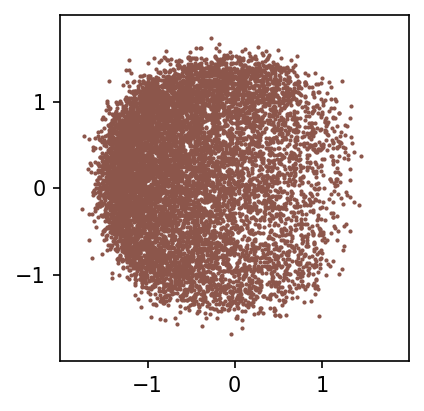

In [13]:
get_plt()
plt.scatter(model1_samples[:,0],model1_samples[:,1], alpha=1., color=palette[5], s=1)
plt.show()

# Denoising score matching to learn the mean

100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  6.13it/s]


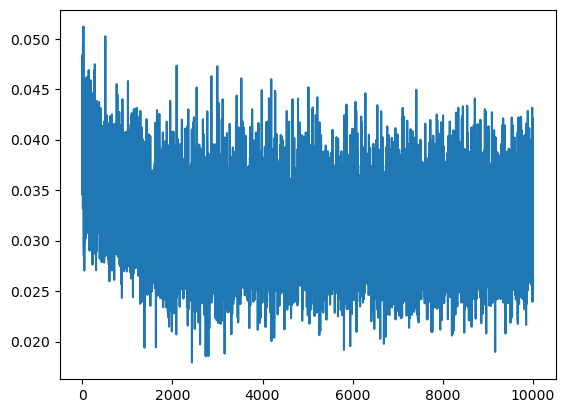

In [7]:
np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])

model2=DenoisingEBM(opt)
loss_list=[]
model2.train()
iterations=int(dataset.size()[0]/opt['batch_size'])
for t in tqdm(range(0,opt['epochs'])):
    for _ in range(0,iterations):
        model2.optimizer.zero_grad()
        indices = np.random.choice(dataset.size()[0],opt['batch_size'])
        batch_x = dataset[indices].to(opt['device'])
        noisy_x=(batch_x+torch.randn_like(batch_x)*opt['noise_std'])
        denoised_x_mean=model2(noisy_x)
        loss= torch.mean((batch_x-denoised_x_mean)**2)
        loss.backward()
        model2.optimizer.step()
        loss_list.append(loss.item())
plt.plot(loss_list)
plt.show()


# 2. $\tilde{x}$-independent isotropic moment matching

In [8]:
np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])
print('Estimated isotropic variance:', model2.isotropic_cov_estimation(dataset).item())
model2.eval()

mmd_loss=MMD_loss(kernel_num=5)
mmd_list=[]
x_init=torch.randn(1,2)*0.1
for _ in range(0,5):
    model2_samples=gibbs_sampler(x_init, model2.sample_isotropic_cov, opt)
    mmd=mmd_loss.forward(source=dataset[0:opt['gibbs_steps']], target=model2_samples.cpu())
    mmd_list.append(mmd.item())

print(np.mean(mmd_list),np.std(mmd_list))

Estimated isotropic variance: 0.031587906181812286


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1075.72it/s]


0.006767526501789689 0.002644171705531181


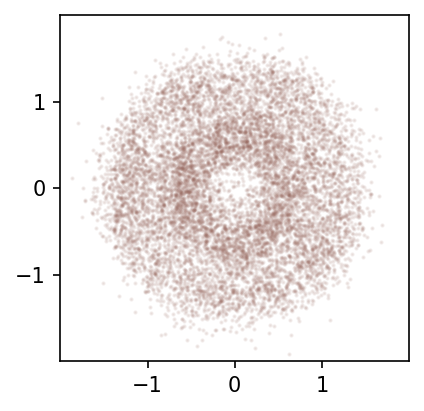

In [9]:
get_plt()
plt.scatter(model2_samples[:,0],model2_samples[:,1], alpha=.1, color=palette[5], s=1)
plt.show()

# 3. The proposed $\tilde{x}$-dependent full moment matching

In [10]:
np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])
model2.eval()

mmd_loss=MMD_loss(kernel_num=5)
mmd_list=[]
x_init=torch.randn(1,2)*0.1
for _ in range(0,5):
    model2_samples=gibbs_sampler(x_init, model2.sample_full_cov, opt)
    mmd=mmd_loss.forward(source=dataset[0:opt['gibbs_steps']], target=model2_samples.cpu())
    mmd_list.append(mmd.item()) 

print(np.mean(mmd_list),np.std(mmd_list))

100%|████████████████████████████████████| 10000/10000 [00:24<00:00, 414.28it/s]


0.004896035883575678 0.0006149228183842688


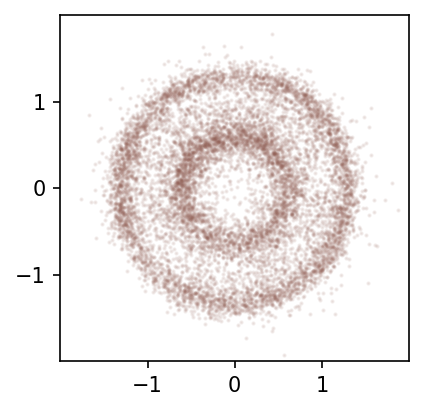

In [11]:
get_plt()
plt.scatter(model2_samples[:,0],model2_samples[:,1], alpha=.1, color=palette[5], s=1)
plt.show()